# ABOUT


Datascientest's Datascientist continuous bootcamp - cohorte Mars2022 -  AeroBOT project

**Tutor**

* Alban THUET

**Authors:**

* Hélène ASSIR
* Hichem HADJI  
* [Ioannis STASINOPOULOS](https://www.linkedin.com/in/ioannis-stasinopoulos/)

</br>

---
</br>

**Version History**

Version | Date       | Author(s)  | Modification
--------|----------- | ---------  | --------------------------
X.X     | XX/XX/2022 | A.B        | modif
1.1     | 04/07/2022 | I.S, H.A.  | Anomaly one-hot encoding
1.0     | 30/06/2022 | I.S, H.A.  | Document creation

This notebook can be executed entirely. 

It

* mounts the GDrive of our AeroBot project @gmail account.

* loads the data from the `train_data_final.pkl` file (cf. `0_test_set_creator_DO_NOT_MODIFY_20220630.ipynb`) under a pandas DataFrame named `df`, which contains `97417` entries and 96 columns.
These data do not contain any more UAS-related entries.

* Performs Feature Engineering: one-hot-encoding of Anomaly using a naive approache, looking directly for the root label into the multiple modalities string of Anomaly
* A comparison of 2 approaches (Naive vs Regex, more complex) was performed, but, with very limited discrepancies between the 2 approaches, we favored the naive one (see : ATTEMPT_1_main_DO_NOT_MODIFY_20220704_Anomaly_ReGex.ipynb).  

Further processing of the data should be perfomed on this dataframe, after having **copied a version of the present notebook**.

# IMPORT PACKAGES


settings for  full / patial Narrative display. Helene?


In [ ]:
#######################
# Import packages
#######################
import numpy as np
import seaborn as sns
import math # for math.pi etc.
import time # time code execution

#######################
# Pandas
#######################
import pandas as pd
# Set pandas settings to show all data when using .head(), .columns etc.
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option("display.colheader_justify","left") # left-justify the print output of pandas

### Display full columnwidth
# Set pandas settings to display full text columns
#pd.options.display.max_colwidth = None
# Restore pandas settings to display standard colwidth
pd.reset_option('display.max_colwidth')

import itertools # Pour créer des iterateurs

# Package to show the progression of pandas operations
from tqdm import tqdm
# from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()
# simply use .progress_apply() instead of .apply() on your pd.DataFram

######################
# PLOTTING
######################
import matplotlib.pyplot as plt
%matplotlib inline
# Define global plot parameters for better readability and consistency among plots
# A complete list of the rcParams keys can be retrieved via plt.rcParams.keys() function
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 23
plt.rcParams['xtick.labelsize'] = 23
plt.rcParams['ytick.labelsize'] = 23
plt.rc('legend', fontsize=23)    # legend fontsize

# BOKEH 
from bokeh.plotting import figure # Importation de la classe figure qui permet de créer un graphique bokeh.
from bokeh.io import  push_notebook, output_notebook, show
output_notebook() # permet d'afficher tous les futurs graphiques dans l'output d'une cellule jupyter. Si cette instruction n'est pas lancée, la figure s'affichera dans un nouvel onglet.
from bokeh.models import ColumnDataSource
from bokeh.transform import dodge
from bokeh.models.tools import HoverTool

#####################
# NLP 
#####################
import re # for Regular Expression handling
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet') # WordNet lemmatizer
nltk.download('omw-1.4') # necessary for WordNet lemmatizer
from nltk.tokenize import word_tokenize # Usual tokenizer
from nltk.tokenize import TweetTokenizer # Special tokenizer;  "we'll", "didn't", etc. are considered as one word
from sklearn.feature_extraction.text import CountVectorizer # Vectorization
from nltk.corpus import stopwords # Import stopwords from nltk.corpus
from nltk.stem.snowball import EnglishStemmer

###############################
# ML preprocessing and models
###############################
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble # random forest
from sklearn.svm import SVC

# EVALUATION tools from sklearn
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, multilabel_confusion_matrix, average_precision_score, precision_recall_curve, PrecisionRecallDisplay

###############################
# Deep Learning
###############################
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras import callbacks


###############################
# Other
###############################
import pickle as pkl # Saving data externally

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# LOAD FUNCTIONS

Functions common to several sections of this code (we should actually put them in a separate file and load them from there)

In [ ]:
def plot_train_history(training_history, metric, anomaly_name):
  """
  Generete plots to monitor the train process
  Inputs: 
  - 'training_history'; use training_history = model.train(...)
  - 'metric' to plot; string e.g. 'accuracy', 'loss'
  - 'anomaly_name' e.g. 'Anomaly_Conflict'. This is used for the plot title
  """
  fig = plt.figure(figsize = (10,4))
  #plt.title(f"{anomaly_name} train history - {metric.upper()}", fontsize = 20)
  train_acc = training_history.history[metric]
  val_acc = training_history.history['val_' + metric] # e.g. 'val_accuracy'

  plt.plot(train_acc, label = f'Training {metric}')
  plt.plot(val_acc, label = f'Validation {metric}')
  plt.xlabel('epochs')
  plt.ylabel(f'{metric}')
  plt.legend()
  plt.show();

# LOAD DATA

## Mount GDrive

In [ ]:
#@title
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive/')

#check your present working directory 
%pwd

Mounted at /content/drive/


'/content'

In [ ]:
#@title
# move to the transformed data location (you can create a deeper structure, if needed, e.g. to save a trained model):
%cd /content/drive/MyDrive/data/transformed/

/content/drive/MyDrive/data/transformed


In [ ]:
#@title
!ls # list the content of the pwd

#!ls "/content/drive/MyDrive/Data_Science/Formations/DataScienceTest/projet/AeroBot/" # list contect of a speficic folder

 complaints-2022-08-05_13_55.csv
'Copy of Qualified abbreviations_20220718.xlsx.gsheet'
'Data Dictionnary.xlsx'
 data_for_BERT_multilabel_20220805.pkl
 model.png
 model_results
 Narrative_PP_stemmed_24072022_TRAIN.pkl
 Narrative_Raw_Stemmed_24072022_TRAIN.pkl
 Narrative_RegEx_subst_21072022_TRAIN.pkl
'Qualified abbreviations_20220707_test.csv'
'Qualified abbreviations_20220708.csv'
'Qualified abbreviations_20220718.csv'
'Qualified abbreviations_20220718_Google_sheet.gsheet'
 test_data_final.pkl
 train_data_final.pkl


## Load data from .pkl file


In [ ]:
#@title
# Load the TRAIN data (97417 entries)
# Do not touch the TEST data until the end of the project!
# or the curse of the greek gods will fall upon you!

%cd /content/drive/MyDrive/data/transformed/
with open("train_data_final.pkl", "rb") as f:
    loaded_data = pkl.load(f)

df = loaded_data[0]
print("\nA Dataframe with", len(df), "entries has been loaded")

/content/drive/MyDrive/data/transformed

A Dataframe with 97417 entries has been loaded


# NARRATIVE ENGINEERING

### Load the pre-processed Narrative data 

See the notebook that performs the substitutions

In [ ]:
# Load the file Narrative_PP_stemmed_21072022_TRAIN.pkl
%cd /content/drive/MyDrive/data/transformed/
with open("Narrative_PP_stemmed_24072022_TRAIN.pkl", "rb") as f:
    loaded_narr = pkl.load(f)

df['Narrative_PP_stemmed'] = loaded_narr[0]
print("Data loaded")

/content/drive/MyDrive/data/transformed
Data loaded


In [ ]:
# Load the file Narrative_PP_stemmed_21072022_TRAIN.pkl
%cd /content/drive/MyDrive/data/transformed/
with open("Narrative_Raw_Stemmed_24072022_TRAIN.pkl", "rb") as f:
    loaded_narr = pkl.load(f)

df['Narrative_Raw_Stemmed'] = loaded_narr[0]
print("Data loaded")

/content/drive/MyDrive/data/transformed
Data loaded


In [ ]:
df.loc[1715282]['Narrative']

"I am writing this report to bring attention to the second departure frequency out of MDW last night. It is a safety issue to give us two frequency changes below 3;000 feet on departure out of MDW.We were in a heavy [aircraft] doing a full power; flaps 25; bleeds off takeoff off of 22L. These takeoffs are known to have very high climb rates; so the intermediate level-off of 3;000 feet approaches fast. At 1;000 feet; we're instructed to contact Departure on 128.2. Simultaneously; I switch frequencies and retract flaps as commanded by the pilot flying. Upon checking in with 128.2; he instructs us to climb and maintain 4;000 feet and subsequently contact 126.62. I dial in 4;000 feet and continue to retract flaps while monitoring a level-off from a climb rate of over 2;000 FPM. At this point; my head turns down to the radio to dial the new Departure frequency in. I check in and they tell us to climb and maintain 12;000 feet. I dial in 12;000 feet; confirm it; reset the autobrake and gear l

In [ ]:
df.loc[1715282]['Narrative_PP_stemmed'][:20]

['write',
 'report',
 'bring',
 'attent',
 'second',
 'departur',
 'frequenc',
 'mdw',
 'last',
 'night',
 'safeti',
 'issu',
 'give',
 'us',
 'two',
 'frequenc',
 'chang',
 '3',
 '000',
 'feet']

In [ ]:
df.loc[1715282]['Narrative_Raw_Stemmed'][:20]

['write',
 'report',
 'bring',
 'attent',
 'second',
 'departur',
 'frequenc',
 'mdw',
 'last',
 'night',
 'safeti',
 'issu',
 'give',
 'us',
 'two',
 'frequenc',
 'chang',
 '3',
 '000',
 'feet']

# TARGET FEATURE ENGINEERING

## Anomaly

This section 

*   drops the entries with NaN in 'Anomaly'
*   creates and adds to the DataFrame 'df' a one-hot column for each Anomaly root label

Root labels are as defined in the ASRS coding form.pdf

We use a naive approach using string parsing 

### Drop the NaNs in Anomaly

In [ ]:
# Drop Anomaly NaN's
print(f"We have {len(df[df['Anomaly'].isna()])} entries where 'Anomaly' == NaN. We drop these entries")

df = df.dropna(axis = 0, how = 'any', subset = ['Anomaly'])
print(f"Current length of our DataFrame: {len(df)}")

We have 431 entries where 'Anomaly' == NaN. We drop these entries
Current length of our DataFrame: 96986


### One-hot encode Anomaly root labels

In [ ]:
# Root label (source = ASRS coding forms)
Anomaly_RootLabels=['Aircraft Equipment',
                    'Airspace Violation',
                    'ATC Issue',
                    'Flight Deck / Cabin / Aircraft Event',
                    'Conflict',
                    'Deviation - Altitude',
                    'Deviation - Speed',
                    'Deviation - Track / Heading',
                    'Deviation / Discrepancy - Procedural',
                    'Ground Excursion',
                    'Ground Incursion',
                    'Ground Event / Encounter',
                    'Inflight Event / Encounter',
                    'No Specific Anomaly Occurred']

#### Naive one-hot encoding

In [ ]:
# Create a column in the df corresponding to each Anomaly root label 'anomaly_rl'
Anomaly_RootLabels_columns = []
for anomaly_rl in Anomaly_RootLabels:
    col='Anomaly_' + anomaly_rl
    Anomaly_RootLabels_columns.append(col)
    # Fill the columns in a one-hot-encoding logic
    df[col] = df['Anomaly'].astype('str').apply(lambda x: 1 if (anomaly_rl in x)  else 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
for anomaly_rl in Anomaly_RootLabels:
    col='Anomaly_'+anomaly_rl
    print('\n',col,'\n',df[col].value_counts())


 Anomaly_Aircraft Equipment 
 0    59054
1    37932
Name: Anomaly_Aircraft Equipment, dtype: int64

 Anomaly_Airspace Violation 
 0    92989
1     3997
Name: Anomaly_Airspace Violation, dtype: int64

 Anomaly_ATC Issue 
 0    81232
1    15754
Name: Anomaly_ATC Issue, dtype: int64

 Anomaly_Flight Deck / Cabin / Aircraft Event 
 0    89839
1     7147
Name: Anomaly_Flight Deck / Cabin / Aircraft Event, dtype: int64

 Anomaly_Conflict 
 0    79622
1    17364
Name: Anomaly_Conflict, dtype: int64

 Anomaly_Deviation - Altitude 
 0    88110
1     8876
Name: Anomaly_Deviation - Altitude, dtype: int64

 Anomaly_Deviation - Speed 
 0    94398
1     2588
Name: Anomaly_Deviation - Speed, dtype: int64

 Anomaly_Deviation - Track / Heading 
 0    88707
1     8279
Name: Anomaly_Deviation - Track / Heading, dtype: int64

 Anomaly_Deviation / Discrepancy - Procedural 
 1    58337
0    38649
Name: Anomaly_Deviation / Discrepancy - Procedural, dtype: int64

 Anomaly_Ground Excursion 
 0    94829
1     

In [ ]:
# Plots
# # Parsing de la colonne 'Anomaly' et top 200 des modalités selon le 1/0 encoding
# for anomaly_rl in Anomaly_RootLabels:
#     col='Anomaly_'+anomaly_rl
    
#     title_plot=col +' : ' + str(sum(df[col]))+' entries of our DF'
#     Anomaly=df[df[col]==1]['Anomaly'].str.split('; ', expand=True).stack().reset_index(drop=True)
#     fig, ax = plt.subplots(figsize=(15,30))
#     sns.countplot(y=Anomaly, order=Anomaly.value_counts().iloc[:50].index,color='green').set(title=title_plot);

#     title_plot='NO '+col +' : ' + str(len(df)-sum(df[col]))+' entries of our DF'
#     Anomaly=df[df[col]==0]['Anomaly'].str.split('; ', expand=True).stack().reset_index(drop=True)
#     fig, ax = plt.subplots(figsize=(15,30))
#     sns.countplot(y=Anomaly, order=Anomaly.value_counts().iloc[:50].index,color='red').set(title=title_plot);

## Crosstable

Make a crosstable and a correlation matrix among Anomaly labels to investigate their mutual relationships.

In [ ]:
anomalies = [ 'Anomaly_Aircraft Equipment', 
              'Anomaly_Airspace Violation',
              'Anomaly_ATC Issue', 
              'Anomaly_Flight Deck / Cabin / Aircraft Event',
              'Anomaly_Conflict', 
              'Anomaly_Deviation - Altitude',
              'Anomaly_Deviation - Speed', 
              'Anomaly_Deviation - Track / Heading',
              'Anomaly_Deviation / Discrepancy - Procedural',
              'Anomaly_Ground Excursion', 
              'Anomaly_Ground Incursion',
              'Anomaly_Ground Event / Encounter',
              'Anomaly_Inflight Event / Encounter',
              'Anomaly_No Specific Anomaly Occurred']
# I got this list from df.columns
# 14 labels

In [ ]:
one_hots = df[anomalies] # DataFrame containing the one-hot representation of Anomaly labels
percentages = []

# Calculate the total number of occurrences of each anomaly 
effectif = one_hots.sum(axis = 0)
effectif = effectif / len(one_hots) # normalize the data wrt to the total # of samples
percentages.append(effectif)

# Loop through the anomalies
for i, anomaly in enumerate(anomalies):

  # Count how many times each anomaly occurs, given the occurence of 'anomaly'
  effectif = one_hots[one_hots[anomaly] == 1].sum(axis = 0)
  effectif = effectif / effectif[i] # normalize the data by the counts of the selected anomaly
  percentages.append(effectif)


# Create a list of titles for the DataFrame to be created
titles = ['TOTAL']
titles += anomalies

percentages = pd.DataFrame(percentages, index = titles)

In [ ]:
percentages

,Anomaly_Aircraft Equipment,Anomaly_Airspace Violation,Anomaly_ATC Issue,Anomaly_Flight Deck / Cabin / Aircraft Event,Anomaly_Conflict,Anomaly_Deviation - Altitude,Anomaly_Deviation - Speed,Anomaly_Deviation - Track / Heading,Anomaly_Deviation / Discrepancy - Procedural,Anomaly_Ground Excursion,Anomaly_Ground Incursion,Anomaly_Ground Event / Encounter,Anomaly_Inflight Event / Encounter,Anomaly_No Specific Anomaly Occurred
TOTAL,0.391108,0.041212,0.162436,0.073691,0.179036,0.091518,0.026684,0.085363,0.601499,0.022240,0.054121,0.075702,0.177376,0.004856
Anomaly_Aircraft Equipment,1.000000,0.010703,0.021011,0.098334,0.020748,0.055178,0.017584,0.051039,0.487609,0.017663,0.007645,0.061979,0.117394,0.000211
Anomaly_Airspace Violation,0.101576,1.000000,0.339755,0.010258,0.162872,0.054791,0.007005,0.134101,0.882662,0.000751,0.021766,0.003753,0.150613,0.000500
Anomaly_ATC Issue,0.050590,0.086200,1.000000,0.007490,0.455630,0.102387,0.025454,0.123270,0.673861,0.002666,0.065761,0.022407,0.181732,0.001460
Anomaly_Flight Deck / Cabin / Aircraft Event,0.521897,0.005737,0.016510,1.000000,0.017770,0.027844,0.020988,0.022527,0.428711,0.004198,0.006296,0.047013,0.107038,0.000280
Anomaly_Conflict,0.045324,0.037491,0.413384,0.007314,1.000000,0.081260,0.012612,0.081778,0.569972,0.009618,0.106427,0.063810,0.089150,0.000346
Anomaly_Deviation - Altitude,0.235804,0.024673,0.181726,0.022420,0.158968,1.000000,0.068612,0.122240,0.846327,0.000225,0.001465,0.003380,0.335737,0.000113
Anomaly_Deviation - Speed,0.257728,0.010819,0.154946,0.057960,0.084621,0.235317,1.000000,0.096213,0.741499,0.014297,0.005796,0.035549,0.475657,0.000386
Anomaly_Deviation - Track / Heading,0.233845,0.064742,0.234569,0.019447,0.171518,0.131054,0.030076,1.000000,0.906027,0.003382,0.015944,0.007730,0.239039,0.000483
Anomaly_Deviation / Discrepancy - Procedural,0.317054,0.060476,0.181977,0.052522,0.169652,0.128769,0.032895,0.128580,1.000000,0.011159,0.081355,0.062019,0.165367,0.000840


### Correlation heatmap

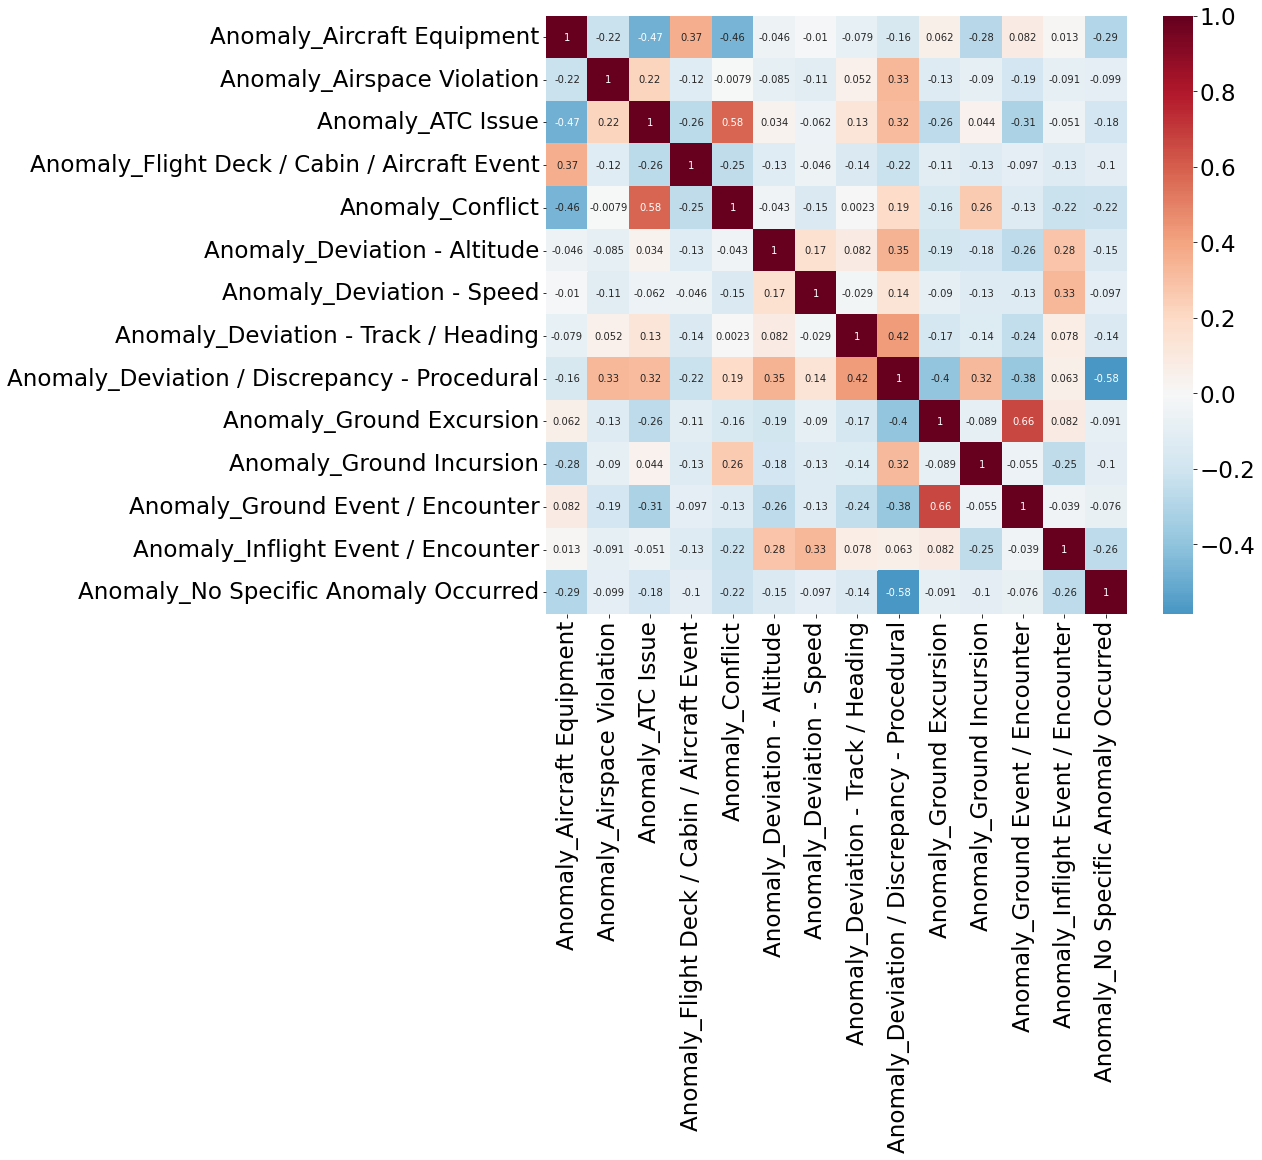

In [ ]:
# Correlation heatmap
plt.figure(figsize=(13, 11))
sns.heatmap(percentages.corr(), annot=True, cmap='RdBu_r', center=0);

### Other representation

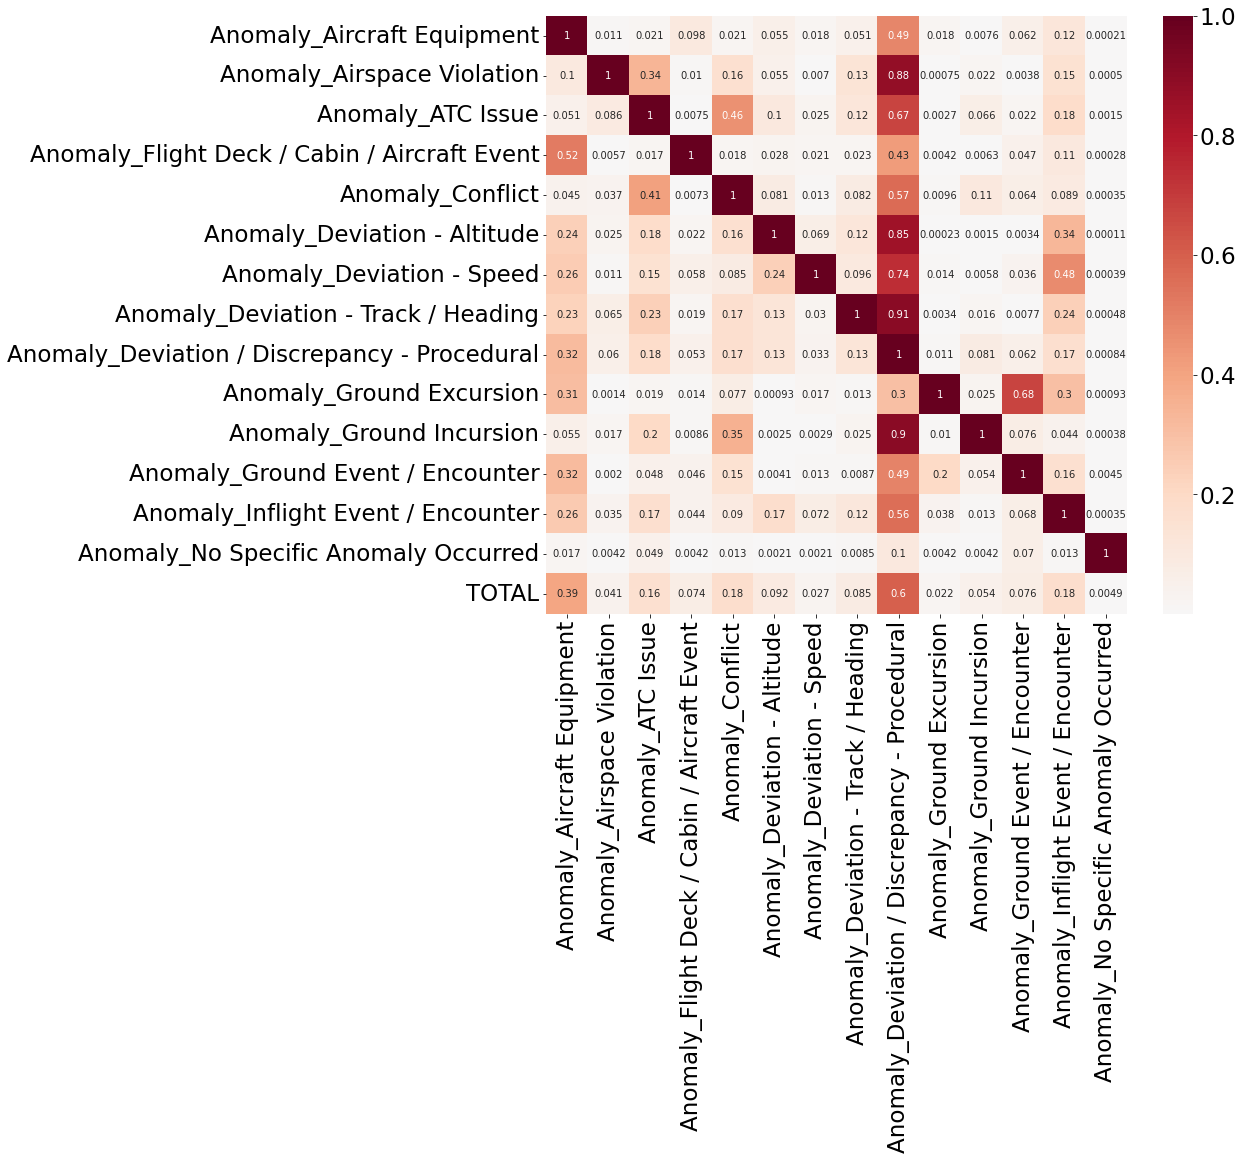

In [ ]:
# other heatmap representation
plt.figure(figsize=(13, 11))
sns.heatmap(percentages, annot=True, cmap='RdBu_r', center=0);

# Multiclass, multilabel classification with Word Embedding


In [ ]:
target = df[anomalies].values
print(target[7:10]) # There are indeed multiple labels for one narrative
print("Shape of target:", target.shape)

[[0 1 1 0 1 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 1 0 0 0 0 0]]
Shape of target: (96986, 14)


In [ ]:
# This should be converted into a class with its attributes and methods...
def word_embedding_multilabel_clf(data, target, maxlen, num_words, N_emb, num_classes, training = True, epochs = 50): 
  """
  Perform multiclass, MULTILABEL classification using WordEmbedding

  Inputs:
  - data as pd.Series, narrative strings, e.g. df['Narrative_PP_stemmed_str']
  
  - target as ndarray, shape = (#samples, #classes) containing 0's and 1's
    A sample may contain several 1's (multilabel context)
  
  - maxlen (int) : length of the text vector (in words). Will ignore narrative content beyond this limit
  
  - num_words (int): desired vocab size; only the most common words are kept
  
  - N_emb (int) = 200: Dimension of embedding (# columns of the embedding matrix)

  - num_classes: number of classes, used in the last Dense() layer

  - training (bool): train or load model from file

  - epochs: # of epochs to train


  Returns:
  - y_pred_proba: The multilabel predictions of our model, i.e. ndarray
  of shape (#samples, #classes) containing probabilities to belong to each class,
  For a given sample, the sum of probabilities may exceed 1 (multilabel context)

  - y_test for performance evaluation outside this function 
   
  - model for saving it
  """ 

  # Time the function execution
  start_time = time.time()
  print(7*'-', f"Execution started...", 7*'-')

  # Train-test split  
  X_text_train, X_text_test, y_train, y_test = train_test_split(data, target, 
                                                      test_size= 0.2,
                                                      random_state = 12) 

  ###############################
  # TOKENIZE
  from tensorflow.keras.preprocessing.text import Tokenizer

  tokenizer = Tokenizer(num_words = num_words, # only the most common words are kept
                        oov_token = 'OOV'
                        ) 
  tokenizer.fit_on_texts(X_text_train) # Updates internal vocabulary based on a list of texts

  # Save the dictionary of correspondence between words and indices
  word2idx = tokenizer.word_index
  # Save the dictionary of correspondence between indices and words
  idx2word = tokenizer.index_word
  # Save the vocab size
  vocab_size = tokenizer.num_words  
  print('Tokenization completed.')
  print(f'Vocabulary size: {vocab_size} (user-defined)\n')
  example_OOV = word2idx['OOV']
  print(f"Example: index of 'OOV': {example_OOV} (Out-Of-Vocabulary label; user-defined)")
  example_aircraft = word2idx['aircraft']
  print(f"Example: index of 'aircraft': {example_aircraft}\n")
  print(30*"-")

  ###############################
  # VECTORIZE NARRATIVES
  # Map each text into a sequence of integers (word indices)
  # We use the vocab obtained from training on the X_text_train data to vectorize both the train and test data
  # Transform every review into a sequence of integers (indices of the vocab)
  X_train = tokenizer.texts_to_sequences(X_text_train)
  X_test = tokenizer.texts_to_sequences(X_text_test)
  print('Vectorization completed.')
  rnd_idx = np.random.randint(len(X_train), size = 2)
  for idx in rnd_idx:
    print(f'Random examples of entries in X_train:\n {X_train[idx]}')
    print(f'Length: {len(X_train[idx])}\n')
  print(30*"-")

  # Pad & truncate train and test sequences (texts transformed in numeric sequences) to make them of the same length
  X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, # Liste des textes transformés en index
                                                          maxlen = maxlen, # Nombre maximal de mots dans un texte. See length analysis above
                                                          padding = 'post', # pad either before or after each sequence
                                                          truncating = 'post', # truncate either before or after each sequence
                                                          value=0.0) # with what to pad
  # if maxlen is not provided, uses the length of the longest sequence in the list.
  X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen = maxlen, padding = 'post', truncating= 'post')
  print('Sequence padding / truncating completed.\n')
  print(f'Each entry in X_train has length: {maxlen} (user-defined)\n')

  for idx in rnd_idx:
    print(f"Entries in X_train now look like this (observe the presence of '1', corresponding to 'OOV'):\n\n {X_train[idx]}\n")
  print(30*"-")  

  if training == True:
    ###############################
    # BUILD THE MODEL
    tf.keras.backend.clear_session()
    # Keras starts with a blank state at each iteration and memory consumption is constant over time.

    model = Sequential(name = "Word_Embedding_model_MULTILABEL_classification") # does not accept spaces
    model.add(Embedding(input_dim = vocab_size, output_dim = N_emb)) # The embedding matrix is a *trainable* parameter
    model.add(GlobalAveragePooling1D()) # no parameters to tune; it's an advantage of GlobalAveragePooling1D
    # Use global average pooling blocks as an alternative to a Flatten() layer 

    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dropout(rate = 0.3)) # prevents overfitting
    model.add(Dense(units = num_classes, activation = 'sigmoid')) # num_classes units, because we have a multiclass (and multilabel) classification problem
    # 'sigmoid' activation because multilabel classification (DO NOT USE softmax, since the classes are not mutualy exclusive)
    print(model.summary())

    ###############################   
    # Define CALLBACKS
    TON = callbacks.TerminateOnNaN() # Callback that terminates training when a NaN loss is encountered

    early_stopping = callbacks.EarlyStopping(monitor = 'binary_accuracy', # 'binary_accuracy' calculates how often predictions match binary labels.
                                            min_delta=0.01,
                                            patience = 7, 
                                            mode = 'max', 
                                            restore_best_weights = True, 
                                            verbose = 1)

    lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'binary_accuracy',
                                            patience = 3, 
                                            verbose = 1, # nombre d'informations qui seront affichées durant l'apprentissage
                                            min_delta=0.01,
                                            mode = 'max')
    ###############################
    # Compile and FIT the model
    opt = keras.optimizers.Adam(#learning_rate = 0.0001 # default learning_rate = 0.001
                                ) 
    model.compile(optimizer = opt, 
                  loss = 'binary_crossentropy', # penalize each output node independently; pick a binary loss and model the output of the network as a independent Bernoulli (sigmoid) distributions per label.
                  metrics = ['accuracy', 'binary_accuracy', 'binary_crossentropy']) # see https://keras.io/api/metrics/

    training_history = model.fit(
              X_train, y_train,
              validation_split = 0.2,
              epochs = epochs, # can be high number; callbacks will stop it earlier anyway
              batch_size = 32, # the higher, the faster one epoch is completed
              callbacks = [TON, early_stopping, lr_plateau
                            ],
              verbose = True)

    ###############################
    # Plot the train history
    plot_train_history(training_history, 'accuracy', '') # '' instead of anomaly_name
    plot_train_history(training_history, 'loss', '')

  if training == False:  # model = loaded model
    %cd /content/drive/MyDrive/data/saved models/Yannis/2022_08_07_WordEmbedding_Multilabel/
    filename = '2022_08_07_WordEmbedding_Multilabel.pkl'
    model = pkl.load(open(filename, 'rb'))

  ###############################
  # EVALUATE
  # The multilabel predictions of our model (probabilities, whose sum may exceed 1 for a given sample)
  y_pred_proba = model.predict(X_test, batch_size=32, verbose=1) 

  # Calculate and print time to execute
  print(7*'-', f"Execution finished!", 7*'-')
  end_time = time.time()
  print(f"--- It took {np.round((end_time - start_time)/60,1)} minutes --- \n\n")

  return y_pred_proba, y_test, model

In [ ]:
tf.keras.losses.BinaryCrossentropy()

In [ ]:
# Join all tokens into a single string
df['Narrative_PP_stemmed_str'] = df['Narrative_PP_stemmed'].apply(lambda token_list: ' '.join(entry for entry in token_list))

In [ ]:
# call the function (decide whether to train or not!)
y_pred_proba, y_test, model = word_embedding_multilabel_clf(data = df['Narrative_PP_stemmed_str'],
                                             epochs = 50,
                                             target = target, 
                                             maxlen = 200, 
                                             num_words = 3000, 
                                             N_emb = 200, 
                                             num_classes = 14,
                                             training = False)

### Evaluate - MULTILABEL context

#### Interpretation of Probabilities

In [ ]:
y_pred_proba.mean(axis = 0)

In [ ]:
y_test.mean(axis = 0)

In [ ]:
col_names = []
for anomaly in anomalies:
  col_names.append('prob_' + anomaly)

pred_prob_df = pd.DataFrame(y_pred_proba, columns = col_names)

plt.figure(figsize=(13, 11))
sns.heatmap(pred_prob_df.corr(), annot=True, cmap='RdBu_r', center=0);

In [ ]:
y_test_df = pd.DataFrame(y_test, columns = anomalies)
df_for_catplot = y_test_df.join(pred_prob_df)
df_for_catplot.head(2)

In [ ]:
for anomaly in anomalies:
  plt.figure()
  name1 = 'prob_' + anomaly
  sns.kdeplot(df_for_catplot[name1], hue= df_for_catplot[anomaly],shade=False)
  plt.xlabel('probability')
  plt.legend('')
  plt.ylim([0,2])
  plt.title(anomaly);

#### Define a threshold

**We define a THRESHOLD. Later we will plot an ROC curve to determine the optimum threshold (probably different for each label)**

In [ ]:
def y_prob_to_y_pred_ML(y_pred_proba, threshold = 0.5):
  """
  Converts probabilities into 0's and 1's. We are still in the MULTILABEL context.
  Input: MULTILABEL predictions (probabilities whose sum for each sample may exceed > 1) coming directly from the model
  Using a user-defined threshold, return a MULTILABEL prediction vector 'y_pred' containing 0's and 1's
  """
  y_pred=[]
  for sample in y_pred_proba:
    y_pred.append([1 if i>= threshold else 0 for i in sample])
  y_pred = np.array(y_pred)

  return y_pred

In [ ]:
y_pred = y_prob_to_y_pred_ML(y_pred_proba, threshold = 0.5) # call the function

In [ ]:
y_pred[1:10]

In [ ]:
y_test[1:10]

#### Classification report

In [ ]:
print(f"\n\n Classification Report: \n {classification_report(y_test, y_pred, target_names = anomalies)}\n")

Note how the 'support' is much higher than len(y_test) due to the multilabels.

In [ ]:
len(y_test)

In [ ]:
metrics.accuracy_score(y_test, y_pred)
# accuracy evaluates whether all the 14-class predictions are correct or not; it is not label-based

In [ ]:
metrics.precision_score(y_test, y_pred, average = None)
# This is the same as the 1st column of the classification report
# The options average = 'micro', average = 'macro' return the 'micro avg' and 'macro avg' for precision, like in the classification report

#### Multilabel Confusion matrix

In [ ]:
multilabel_confusion_matrix(y_test, y_pred)

In [ ]:
# Confusion matrix for each label
mult_lbl_conf_mat = multilabel_confusion_matrix(y_test, y_pred)
classes = [0,1]
labels = anomalies

for i in range(mult_lbl_conf_mat.shape[0]): # iterate through the amount of classes
  cnf_matrix = mult_lbl_conf_mat[i]

  plt.figure(figsize = (10,5))
  plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
  plt.title(f"{labels[i]}")
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, cnf_matrix[i, j],
              horizontalalignment = "center",
              color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('True labels')
  plt.xlabel('Predicted labels')
  plt.show()

# Run model again 

------- Execution started... -------
Tokenization completed.
Vocabulary size: 3000 (user-defined)

Example: index of 'OOV': 1 (Out-Of-Vocabulary label; user-defined)
Example: index of 'aircraft': 2

------------------------------
Vectorization completed.
Random examples of entries in X_train:
 [652, 103, 222, 81, 1013, 24, 1395, 130, 24, 269, 173, 227, 1, 767, 269, 414, 1, 1, 1, 1, 637, 1868, 637, 220, 1501, 161, 215, 34, 34, 89, 6, 34, 77, 22, 100, 108, 946, 369, 941, 1, 2056, 323, 177, 1, 1, 543, 54, 132, 466, 1163, 64, 132, 767, 227, 1]
Length: 55

Random examples of entries in X_train:
 [309, 2712, 1635, 127, 58, 97, 7, 1207, 481, 981, 190, 18, 190, 7, 26, 9, 1071, 92, 586, 4, 689, 4, 512, 165, 31, 117, 806, 432, 2, 73, 144, 45, 7, 23, 9, 240, 58, 7, 102, 455, 240, 94, 115, 18, 91, 891, 891, 436, 436, 31, 31, 83, 359, 165, 619, 224, 1388, 57, 546, 9, 1, 196, 219, 532, 359, 806, 2, 376, 9, 224, 1672, 57, 315, 1263, 642, 1, 1573, 148, 359, 341, 371, 371, 399, 9, 93, 193, 123, 1, 436,

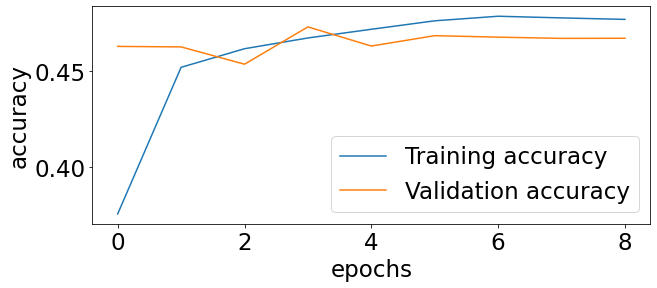

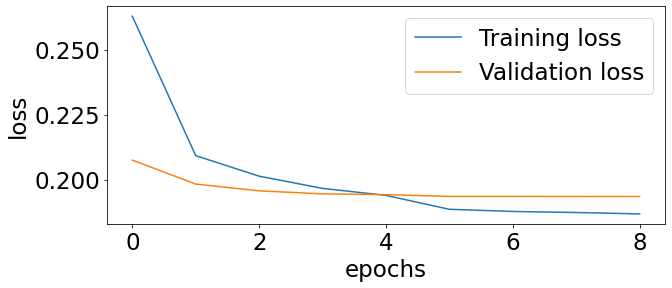

607/607 [==============================] - 1s 2ms/step
------- Execution finished! -------
--- It took 3.5 minutes --- 




In [ ]:
# call the function with shorter maxlen
y_pred_proba, y_test, model = word_embedding_multilabel_clf(data = df['Narrative_PP_stemmed_str'],
                                             epochs = 50,
                                             target = target, 
                                             maxlen = 50, 
                                             num_words = 3000, 
                                             N_emb = 200, 
                                             num_classes = 14,
                                             training = True)

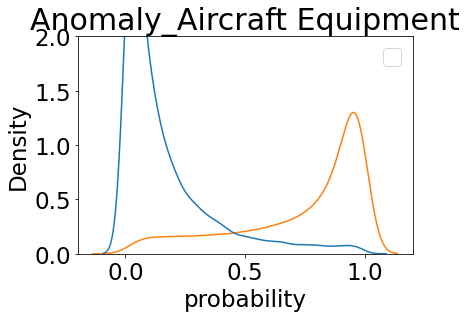

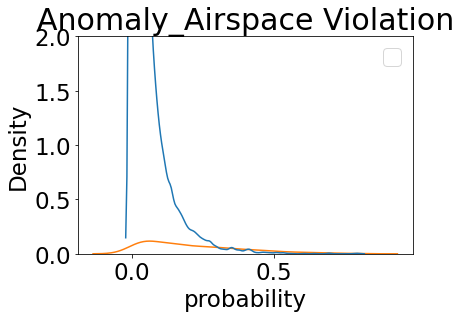

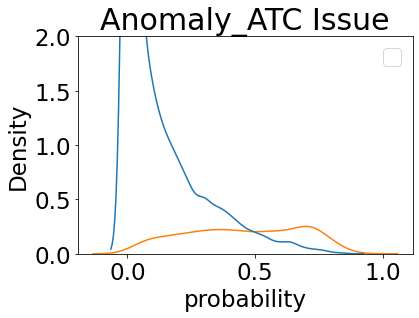

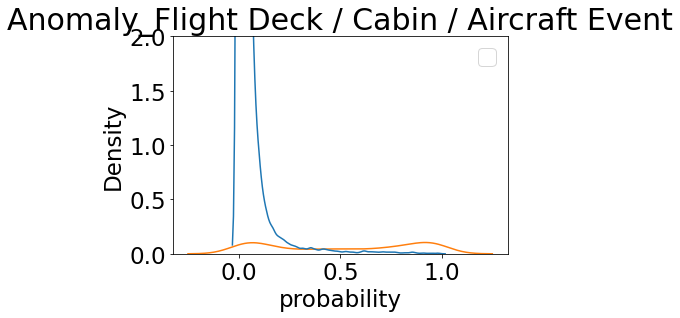

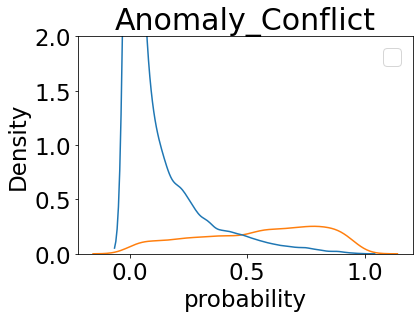

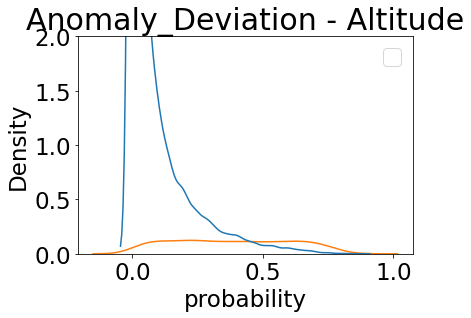

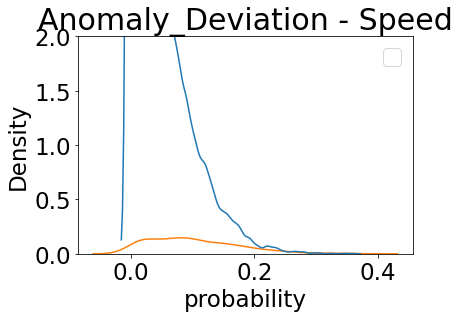

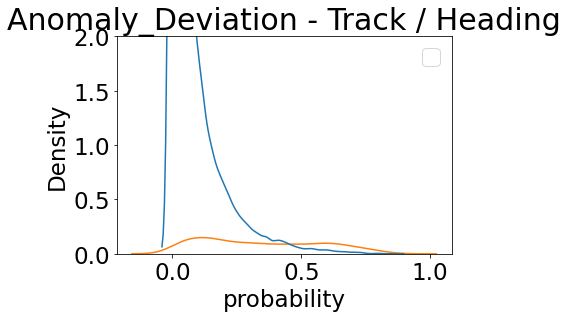

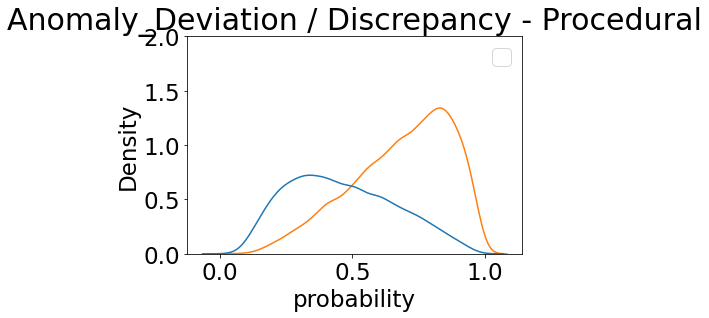

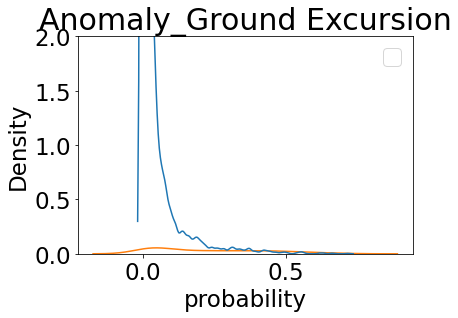

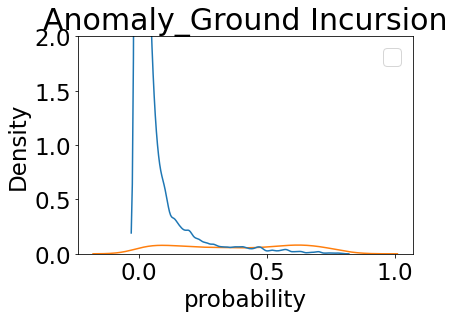

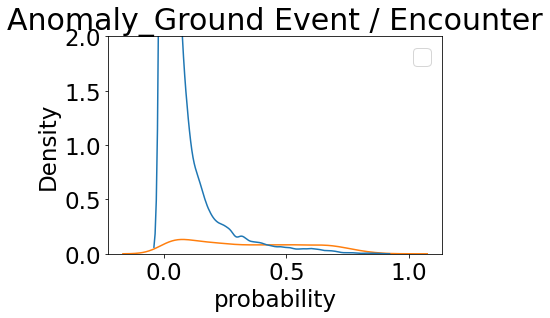

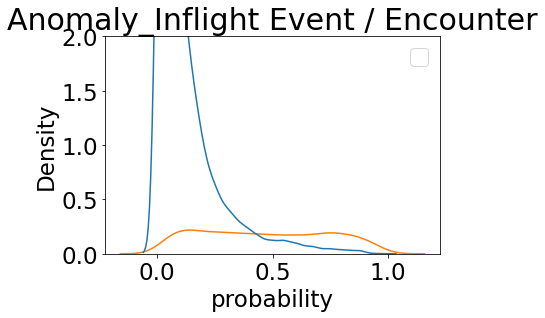

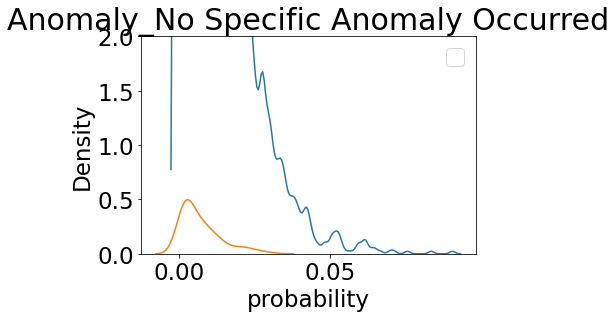

In [ ]:
# DataFrame ontaining the predicted probability and y_test for each Anomaly

# DataFrame containing the predicted probability for each Anomaly
# Create columns
col_names = []
for anomaly in anomalies:
  col_names.append('prob_' + anomaly)
# Write data into df
pred_prob_df = pd.DataFrame(y_pred_proba, columns = col_names)

# DataFrame containing y_test data
y_test_df = pd.DataFrame(y_test, columns = anomalies)

# Join the 2 DataFrames
df_for_catplot = y_test_df.join(pred_prob_df)

# Plot probability distributions
for anomaly in anomalies:
  plt.figure()
  name1 = 'prob_' + anomaly
  sns.kdeplot(df_for_catplot[name1], hue= df_for_catplot[anomaly],shade=False)
  plt.xlabel('probability')
  plt.legend('')
  plt.ylim([0,2])
  plt.title(anomaly);